In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(11, 9)

In [3]:
### Collect data
url_confirmed = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_confirmed)

url_deaths = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(url_deaths)

url_recovered = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'
recovered = pd.read_csv(url_recovered)

In [4]:
print('confirmed shape', confirmed.shape)
print('deaths shape', deaths.shape)
print('recovered shape', recovered.shape)
date_cols = deaths.columns[4:]

confirmed shape (263, 81)
deaths shape (263, 81)
recovered shape (249, 81)


In [5]:
deaths['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [6]:
def metrics(country, metric):
    if metric == 'deaths':
        return deaths[deaths['Country/Region'] == country][date_cols].sum()
    if metric == 'confirmed':
        return confirmed[confirmed['Country/Region'] == country][date_cols].sum()
    if metric == 'recovered':
        return recovered[recovered['Country/Region'] == country][date_cols].sum()
    else:
        d = deaths[deaths['Country/Region'] == country][date_cols].sum()
        c = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return d/c

def metrics_plt(countries,m):
    for country in countries:
        metrics(country,m).plot(label=country)
    plt.legend()
    plt.title(m)

In [7]:
def grads(country, metric):
    if metric == 'deaths':
        a = deaths[deaths['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    if metric == 'confirmed':
        a = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    if metric == 'recovered':
        a = recovered[recovered['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    else:
        d = deaths[deaths['Country/Region'] == country][date_cols].sum()
        c = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(d/c)), index = date_cols)

def grads_plt(countries,m):
    for country in countries:
        a = grads(country,m)
        a.plot(label=country)
        plt.legend()
        plt.title(m)

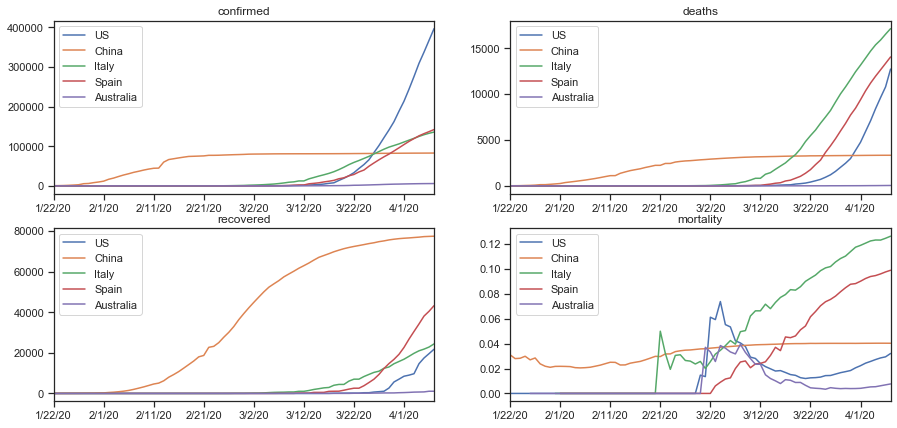

In [8]:
countries = ['US','China','Italy', 'Spain','Australia']
metrics_list = ['confirmed', 'deaths', 'recovered', 'mortality']

figsize(15, 7)
for k, m in enumerate(metrics_list):
    sx = plt.subplot(2, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    metrics_plt(countries,m)

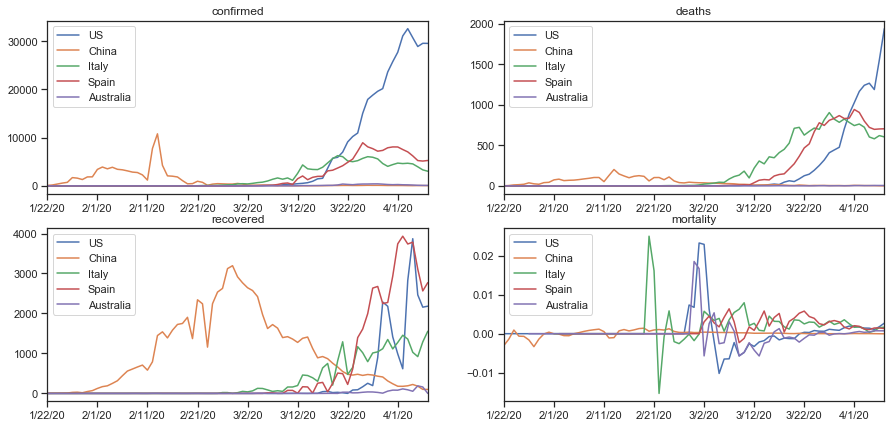

In [9]:
## Gradients
figsize(15, 7)
for k, m in enumerate(metrics_list):
    sx = plt.subplot(2, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    grads_plt(countries,m)

# Forcasting Deaths
## Prepare the data for an LSTM model 

This is based on the tutorial https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

In [11]:
countries = ['US','China','Italy', 'Spain','Australia','Singapore',
             'Korea, South','France','Germany','United Kingdom',
             'Belgium','Netherlands']
L = date_cols.to_list()
L.insert(0,'Country/Region')
filtr = deaths[deaths['Country/Region'].isin(countries)]
agg = filtr[L].groupby(['Country/Region']).sum()
data = agg[date_cols]
training_set = data[date_cols]

In [12]:
data

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Australia,0,0,0,0,0,0,0,0,0,0,...,16,17,18,20,24,28,30,35,40,45
Belgium,0,0,0,0,0,0,0,0,0,0,...,431,513,705,828,1011,1143,1283,1447,1632,2035
China,17,18,26,42,56,82,131,133,171,213,...,3304,3308,3309,3316,3322,3326,3330,3333,3335,3335
France,0,0,0,0,0,0,0,0,0,0,...,2611,3030,3532,4043,5398,6520,7574,8093,8926,10343
Germany,0,0,0,0,0,0,0,0,0,0,...,533,645,775,920,1107,1275,1444,1584,1810,2016
Italy,0,0,0,0,0,0,0,0,0,0,...,10779,11591,12428,13155,13915,14681,15362,15887,16523,17127
"Korea, South",0,0,0,0,0,0,0,0,0,0,...,152,158,162,165,169,174,177,183,186,192
Netherlands,0,0,0,0,0,0,0,0,0,0,...,772,865,1040,1175,1341,1490,1656,1771,1874,2108
Singapore,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,4,5,6,6,6,6


In [13]:
def sliding_windows(data, seq_length):
    x = {}
    y = {}
    for j in range(data.shape[0]):
        x[j] = []
        y[j] = []
        for i in range(data.shape[1]-seq_length-1):
            _x = data[j,i:(i+seq_length)]
            _y = np.array([data[j,i+seq_length]]) ## Need each y element to be an array
            x[j].append(_x)
            y[j].append(_y)
    return x,y

sc = StandardScaler()
training_data = sc.fit_transform(training_set.transpose()).transpose() ## Need to transpose to scale the countries

seq_length = 7 ## Use the previous 7 days to predict the next day
x, y = sliding_windows(training_data, seq_length)

In [14]:
trainX = {}
trainY = {}
testX = {}
testY = {}

for cntry in range(len(data.index)):
    trainX[data.index[cntry]] = []
    trainY[data.index[cntry]] = []
    testX[data.index[cntry]] = []
    testY[data.index[cntry]] = []
    
    train_size = int(len(y[cntry]) * 0.8)
    test_size = len(y[cntry]) - train_size

    dataX = Variable(torch.Tensor(np.array(x[cntry])))
    dataY = Variable(torch.Tensor(np.array(y[cntry])))

    trainX_ = Variable(torch.Tensor(np.array(x[cntry][0:train_size])))
    trainY_ = Variable(torch.Tensor(np.array(y[cntry][0:train_size])))

    testX_ = Variable(torch.Tensor(np.array(x[cntry][train_size:len(x[cntry])])))
    testY_ = Variable(torch.Tensor(np.array(y[cntry][train_size:len(y[cntry])])))
    
    trainX[data.index[cntry]].append(trainX_)
    trainY[data.index[cntry]].append(trainY_)
    testX[data.index[cntry]].append(testX_)
    testY[data.index[cntry]].append(testY_)

In [15]:
train_inout_seq = []
for country in countries:
    for z in zip(trainX[country][0], trainY[country][0]):
        train_inout_seq.append(z)
print(len(train_inout_seq))

660


## Define and train a model

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [17]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [18]:
epochs = 226

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03868893
epoch:  26 loss: 0.00000589
epoch:  51 loss: 0.00023374
epoch:  76 loss: 0.00009354
epoch: 101 loss: 0.00005369
epoch: 126 loss: 0.00000025
epoch: 151 loss: 0.00001803
epoch: 176 loss: 0.00001079
epoch: 201 loss: 0.00002257
epoch: 225 loss: 0.0000007415


## Evaluate on the test data

In [19]:
## Return the predicted and actual values back to their original scale
scored = []
for country in countries:
    scored.append(score(country))
unscaled_scores = sc.inverse_transform(pd.DataFrame(scored, index=countries).transpose()).transpose()

actuals = []
for cntry in countries:
    actuals.append(testY[cntry][0].flatten())
unscaled_actuals = sc.inverse_transform(pd.DataFrame(actuals, index=countries).transpose()).transpose()

NameError: name 'score' is not defined

In [ ]:
def plt_predictions(cntry):
    preds = unscaled_scores[countries.index(cntry)]
    actuals = unscaled_actuals[countries.index(cntry)]
    range_values = len(testX[cntry][0])
    xlabels = date_cols[-range_values:]
    plt.plot(actuals, label='actual')
    plt.plot(preds, label='predicted')
    plt.xticks(ticks = range(range_values), labels = xlabels, rotation = 'vertical')
    plt.legend()
    plt.title(cntry)

In [ ]:
figsize(40, 20)
for k, cntry in enumerate(countries):
    sx = plt.subplot(int(len(countries)/2)+1, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    plt_predictions(cntry)